Выдвенем предположение о том, что все наши наблюдения, скорее всего, выглядят как некий эллипсоид в подпространстве нашего исходного пространства и наш новый базис в этом пространстве совпадает с осями этого эллипсоида. Это предположение позволяет нам одновременно избавиться от сильно скоррелированных признаков, так как вектора базиса пространства, на которое мы проецируем, будут ортогональными.

Предположение о том, что данные лежат в подпространстве меньшей размерности, позволяет нам отбросить "лишнее" подпространство в новой проекции, а именно то подпространство, вдоль осей которого эллипсоид будет наименее растянут. Мы будем это делать "жадно", выбирая по-очереди в качестве нового элемента базиса нашего нового подпространства последовательно ось эллипсоида из оставшихся, вдоль которой дисперсия будет максимальной.

<img src="0.png" width="550">
<img src="1.png">
<img src="2.png">
<img src="3.png" width="750">

Дальнейшие шаги просты: надо умножить нашу матрицу данных на эти компоненты и мы получим проекцию наших данных в ортогональном базисе этих компонент. Теперь если мы транспонируем нашу матрицу данных и матрицу векторов главных компонент, то мы восстановим исходную выборку в том пространстве, из которого мы делали проекцию на компоненты. Если количество компонент было меньше размерности исходного пространства, мы потеряем часть информации при таком преобразовании.

---
---
---

In [1]:
import numpy as np
from sklearn import decomposition
from sklearn import datasets
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
import seaborn as sns 
sns.set(style='white')
%matplotlib inline

In [2]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

[Text(0.0, 0, ''),
 Text(1.0, 0, ''),
 Text(2.0, 0, ''),
 Text(3.0, 0, ''),
 Text(4.0, 0, ''),
 Text(5.0, 0, ''),
 Text(6.0, 0, ''),
 Text(7.0, 0, ''),
 Text(8.0, 0, '')]

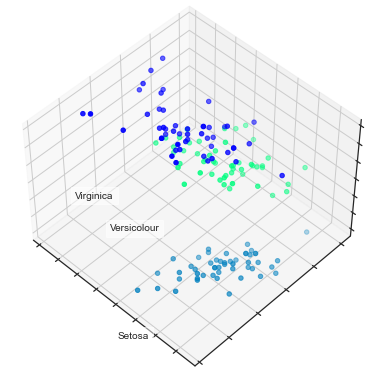

In [3]:
fig = plt.figure(1, figsize=(6, 5))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()

for name, label in [('Setosa', 0), ('Versicolour', 1), ('Virginica', 2)]:
    ax.text3D(X[y == label, 0].mean(),
              X[y == label, 1].mean() + 1.5,
              X[y == label, 2].mean(), name,
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
    
# Поменяем порядок цветов меток, чтобы они соответствовали правильному
y_clr = np.choose(y, [1, 2, 0]).astype(np.float)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y_clr, cmap=plt.cm.winter)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

Посмотрим, насколько PCA улучшит результаты для модели, которая в данном случае плохо справится с классификацией из-за того, что у неё не хватит сложности для описания данных:

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, 
                                                    stratify=y, 
                                                    random_state=42)

In [6]:
clf = DecisionTreeClassifier(max_depth=2, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)

print('Accuracy: {:.5f}'.format( accuracy_score(y_test,preds.argmax(axis=1)) ))

Accuracy: 0.88889


In [7]:
# Прогоним встроенный в sklearn PCA
pca = decomposition.PCA(n_components=2)
X_centered = X - X.mean(axis=0)
pca.fit(X_centered)
X_pca = pca.transform(X_centered)

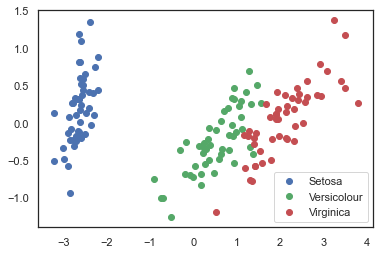

In [8]:
# Нарисуем получившиеся точки в нашем новом пространстве
plt.plot(X_pca[y == 0, 0], X_pca[y == 0, 1], 'bo', label='Setosa')
plt.plot(X_pca[y == 1, 0], X_pca[y == 1, 1], 'go', label='Versicolour')
plt.plot(X_pca[y == 2, 0], X_pca[y == 2, 1], 'ro', label='Virginica')

plt.legend(loc=0);

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=.3, 
                                                    stratify=y, 
                                                    random_state=42)

In [10]:
clf = DecisionTreeClassifier(max_depth=2, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)

print('Accuracy: {:.5f}'.format( accuracy_score(y_test, preds.argmax(axis=1)) ))

Accuracy: 0.91111


Видно, что качество возросло незначительно, но для более сложных данных более высокой размерности, где данные не разбиваются тривиально вдоль одного признака, применение PCA может значимо улучшить качество работы деревьев решений и ансамблей на их основе.

Посмотрим на 2 главные компоненты в последнем PCA-представлении данных и на тот процент исходной дисперсии в даных, который они "объясняют":

In [11]:
for i, component in enumerate(pca.components_):
    print("{} component: {}% of initial variance".format(i + 1, 
                                                  round(100 * pca.explained_variance_ratio_[i], 2)
                                                        ))
    print(" + ".join("%.3f x %s" % (value, name)
                     for value, name in zip(component, iris.feature_names)
                    ))
    print("\n")

1 component: 92.46% of initial variance
0.361 x sepal length (cm) + -0.085 x sepal width (cm) + 0.857 x petal length (cm) + 0.358 x petal width (cm)


2 component: 5.31% of initial variance
0.657 x sepal length (cm) + 0.730 x sepal width (cm) + -0.173 x petal length (cm) + -0.075 x petal width (cm)




---

Возьмем набор данных по рукописным цифрам:

In [12]:
digits = datasets.load_digits()
X = digits.data
y = digits.target

Картинки здесь представляются матрицей 8 x 8 (интенсивности белого цвета для каждого пикселя). Далее эта матрица "разворачивается" в вектор длины 64, получается признаковое описание объекта:

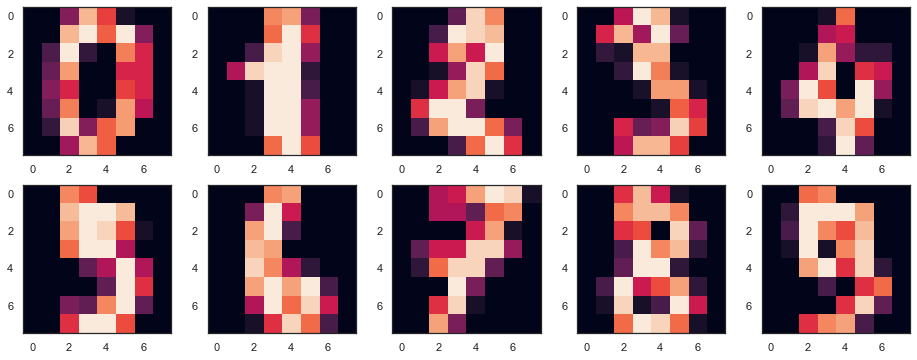

In [13]:
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[i,:].reshape([8,8]));

Получается, размерность признакового пространства здесь – 64. Но давайте снизим размерность всего до 2 и увидим, что даже на глаз рукописные цифры неплохо разделяются на кластеры:

In [14]:
%%time
pca = decomposition.PCA(n_components=2)
X_reduced = pca.fit_transform(X)

print('Projecting %d-dimensional data to 2D' % X.shape[1])

Projecting 64-dimensional data to 2D
CPU times: user 18 ms, sys: 3.47 ms, total: 21.4 ms
Wall time: 10.1 ms


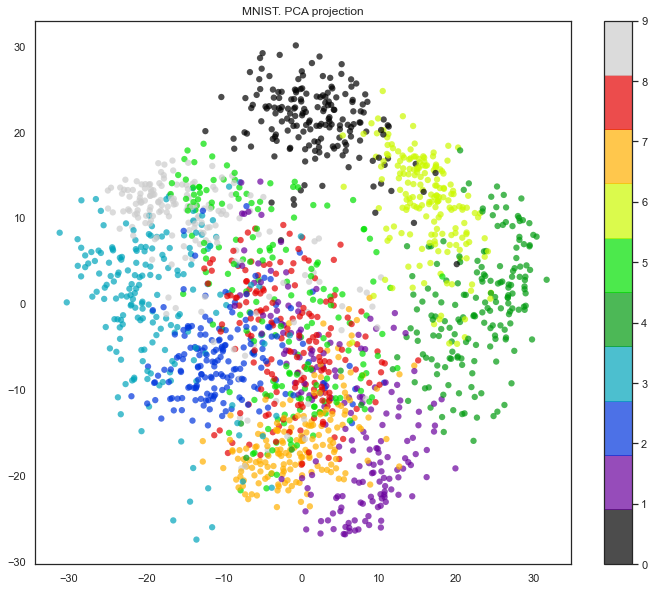

In [15]:
plt.figure(figsize=(12,10))
plt.title('MNIST. PCA projection')
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, 
                edgecolor='none', alpha=0.7, s=40,
                cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()

Правда, с t-SNE картинка получается еще лучше, поскольку у PCA ограничение – он находит только линейные комбинации исходных признаков. Зато даже на этом относительно небольшом наборе данных можно заметить, насколько t-SNE дольше работает:

In [16]:
from sklearn.manifold import TSNE

In [17]:
%%time
tsne = TSNE(random_state=17)
X_tsne = tsne.fit_transform(X)

CPU times: user 43.9 s, sys: 1.41 s, total: 45.3 s
Wall time: 14.2 s


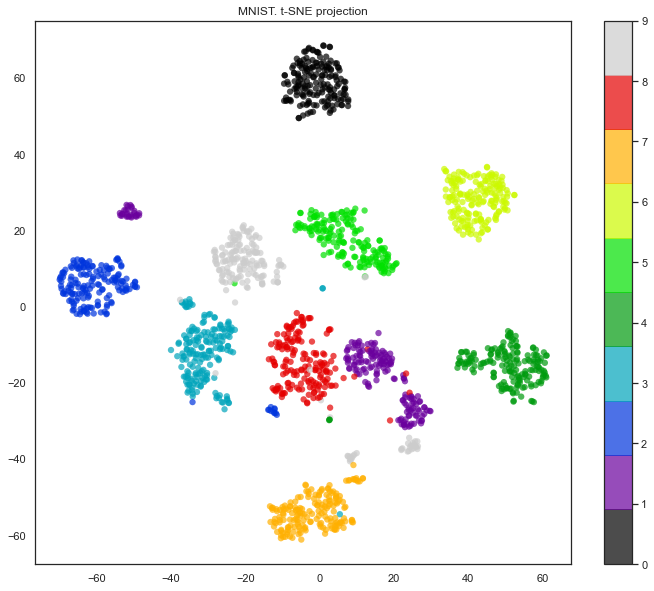

In [18]:
plt.figure(figsize=(12,10))
plt.title('MNIST. t-SNE projection')
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()

На практике, как правило, выбирают столько главных компонент, чтобы оставить 90% дисперсии исходных данных. В данном случае для этого достаточно выделить 21 главную компоненту, то есть снизить размерность с 64 признаков до 21:

In [19]:
pca = decomposition.PCA().fit(X)

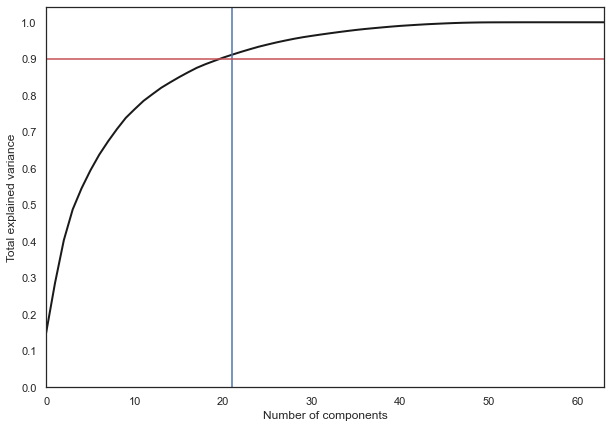

In [20]:
plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 63)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(21, c='b')
plt.axhline(0.9, c='r')
plt.show();

In [21]:
%%time
pca = decomposition.PCA(n_components=21)
X_reduced = pca.fit_transform(X)

CPU times: user 26.7 ms, sys: 4.42 ms, total: 31.1 ms
Wall time: 16.1 ms


---
---
---

<img src="5.png">

Алгоритм **К-средних**, вероятно, самый популярный и простой алгоритм кластеризации и очень легко представляется в виде простого псевдокода:

1. Выбрать количество кластеров , которое нам кажется оптимальным для наших данных.
2. Высыпать случайным образом в пространство наших данных  точек (центроидов).
3. Для каждой точки нашего набора данных посчитать, к какому центроиду она ближе.
4. Переместить каждый центроид в центр выборки, которую мы отнесли к этому центроиду.
5. Повторять последние два шага фиксированное число раз, либо до тех пор пока центроиды не "сойдутся" (обычно это значит, что их смещение относительно предыдущего положения не превышает какого-то заранее заданного небольшого значения).

Само по себе решение задачи K-means NP-трудное.

В случае обычной евклидовой метрики для точек лежащих на плоскости, этот алгоритм очень просто расписывается аналитически и рисуется. Давайте посмотрим соответствующий пример:

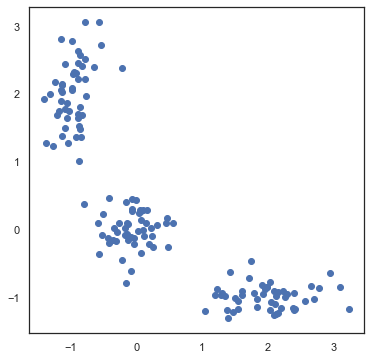

In [22]:
# Начнём с того, что насыпем на плоскость три кластера точек
X = np.zeros((150, 2))

np.random.seed(seed=42)
X[:50, 0] = np.random.normal(loc=0.0, scale=.3, size=50)
X[:50, 1] = np.random.normal(loc=0.0, scale=.3, size=50)

X[50:100, 0] = np.random.normal(loc=2.0, scale=.5, size=50)
X[50:100, 1] = np.random.normal(loc=-1.0, scale=.2, size=50)

X[100:150, 0] = np.random.normal(loc=-1.0, scale=.2, size=50)
X[100:150, 1] = np.random.normal(loc=2.0, scale=.5, size=50)

plt.figure(figsize=(6, 6))
plt.plot(X[:, 0], X[:, 1], 'bo');

In [23]:
# В scipy есть замечательная функция, которая считает расстояния
# между парами точек из двух массивов, подающихся ей на вход
from scipy.spatial.distance import cdist

In [24]:
# Прибьём рандомность и насыпем три случайные центроиды для начала
np.random.seed(seed=42)
centroids = np.random.normal(loc=0.0, scale=1., size=6)
centroids = centroids.reshape((3, 2))

cent_history = []
cent_history.append(centroids)

for i in range(3):
    # Считаем расстояния от наблюдений до центроид
    distances = cdist(X, centroids)
    # Смотрим, до какой центроиде каждой точке ближе всего
    labels = distances.argmin(axis=1)

    # Положим в каждую новую центроиду геометрический центр её точек
    centroids = centroids.copy()
    centroids[0, :] = np.mean(X[labels == 0, :], axis=0)
    centroids[1, :] = np.mean(X[labels == 1, :], axis=0)
    centroids[2, :] = np.mean(X[labels == 2, :], axis=0)

    cent_history.append(centroids)

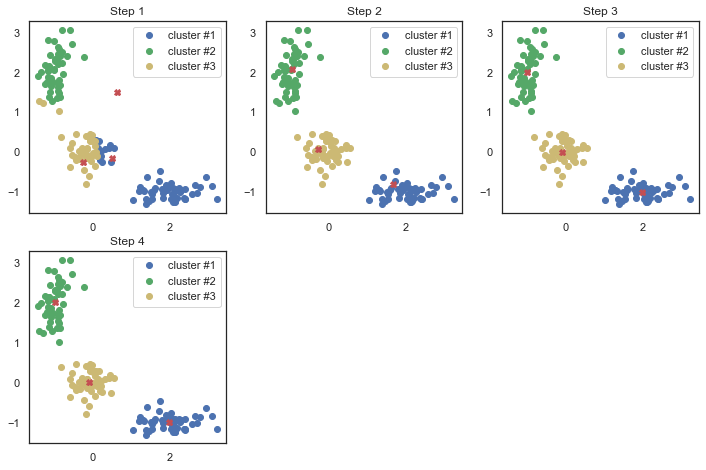

In [25]:
# А теперь нарисуем всю эту красоту
plt.figure(figsize=(12, 12))
for i in range(4):
    distances = cdist(X, cent_history[i])
    labels = distances.argmin(axis=1)

    plt.subplot(3, 3, i + 1)
    plt.title('Step {:}'.format(i + 1));
    
    plt.plot(X[labels == 0, 0], X[labels == 0, 1], 'bo', label='cluster #1')
    plt.plot(X[labels == 1, 0], X[labels == 1, 1], 'go', label='cluster #2')
    plt.plot(X[labels == 2, 0], X[labels == 2, 1], 'yo', label='cluster #3')
    plt.plot(cent_history[i][:, 0], cent_history[i][:, 1], 'rX')
    
    plt.legend(loc=0)

Особенностью этого алгоритма является то, что он чувствителен к исходному положению центроид кластеров в пространстве. В такой ситуации спасает несколько последовательных запусков алгоритма с последующим усреднением полученных кластеров.

---

В отличие от задачи классификации или регресии, в случае кластеризации сложнее выбрать критерий, с помощью которого было бы просто представить задачу кластеризации как задачу оптимизации.
<br>В случае kMeans распространен вот такой критерий – сумма квадратов расстояний от точек до центроидов кластеров, к которым они относятся:
$$J(C) = \sum_{k=1}^{K}\sum_{i \in C_k} ||x_i - \mu_k||^{2} \rightarrow \underset{\rm C}{\rm min},$$


здесь  – множество кластеров мощности ,  – центроид кластера .


Понятно, что здравый смысл в этом есть: мы хотим, чтобы точки располагались кучно возле центров своих кластеров. Но вот незадача: минимум такого функционала будет достигаться тогда, когда кластеров столько же, сколько и точек (то есть каждая точка – это кластер из одного элемента).
<br>Для решения этого вопроса (выбора числа кластеров) часто пользуются такой эвристикой: выбирают то число кластеров, начиная с которого описанный функционал  падает "уже не так быстро". Или более формально:
$$D(k) = \frac{|J(C_k)-J(C_{k+1})|}{|J(C_{k-1})-J(C_k)|} \rightarrow \underset{\rm k}{\rm min}$$

Рассмотрим пример:

In [26]:
from sklearn.cluster import KMeans

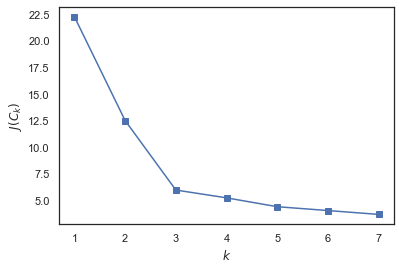

In [27]:
inertia = []
for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, 8), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

Видим, что $J(C_k)$ падает весомо при увеличении числа кластеров с 1 до 2 и с 2 до 3, и уже не так весомо при изменении $k$ с 3 до 4. Значит, в данной задаче оптимально задать 3 кластера.

---

Вероятно, самый простой и понятный алгоритм кластеризации без фиксированного числа кластеров — **агломеративная кластеризация**. Интуиция у алгоритма очень простая:

1. Начинаем с того, что высыпаем на каждую точку свой кластер.
2. Сортируем попарные расстояния между центрами кластеров по возрастанию.
3. Берём пару ближайших кластеров, склеиваем их в один и пересчитываем центр кластера.
4. Повторяем п. 2 и 3 до тех пор, пока все данные не склеятся в один кластер.

Сам процесс поиска ближайших кластеров может происходить с использованием разных методов объединения точек:

- Single linkage — минимум попарных расстояний между точками из двух кластеров.
- Complete linkage — максимум попарных расстояний между точками из двух кластеров.
- Average linkage — среднее попарных расстояний между точками из двух кластеров.
- Centroid linkage — расстояние между центроидами двух кластеров.

Данный алгоритм имеет высокую алгоритмическую сложность.

In [28]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

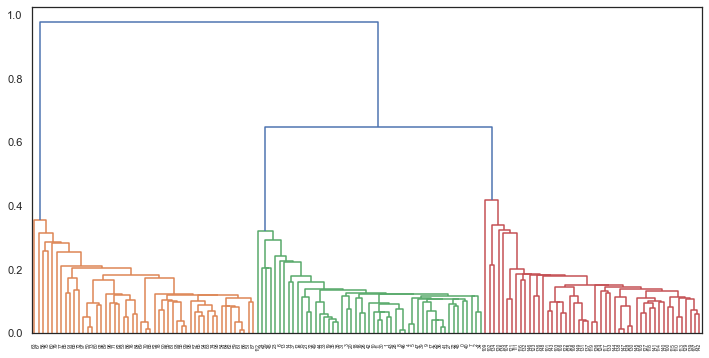

In [29]:
X = np.zeros((150, 2))

np.random.seed(seed=42)
X[:50, 0] = np.random.normal(loc=0.0, scale=.3, size=50)
X[:50, 1] = np.random.normal(loc=0.0, scale=.3, size=50)

X[50:100, 0] = np.random.normal(loc=2.0, scale=.5, size=50)
X[50:100, 1] = np.random.normal(loc=-1.0, scale=.2, size=50)

X[100:150, 0] = np.random.normal(loc=-1.0, scale=.2, size=50)
X[100:150, 1] = np.random.normal(loc=2.0, scale=.5, size=50)

distance_mat = pdist(X) # pdist посчитает нам верхний треугольник матрицы попарных расстояний

Z = hierarchy.linkage(distance_mat, 'single') # linkage — реализация агломеративного алгоритма
plt.figure(figsize=(12, 6))
dn = hierarchy.dendrogram(Z, color_threshold=0.5)

---

И напоследок давайте посмотрим на эти метрики для наших алгоритмов, запущенных на данных рукописных цифр MNIST:

In [30]:
import pandas as pd
from sklearn import metrics
from sklearn import datasets
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, SpectralClustering

import warnings
warnings.filterwarnings("ignore")

In [31]:
data = datasets.load_digits()
X, y = data.data, data.target

algorithms = []
algorithms.append(KMeans(n_clusters=10, random_state=1))
algorithms.append(AffinityPropagation())
algorithms.append(SpectralClustering(n_clusters=10, random_state=1,
                                     affinity='nearest_neighbors'))
algorithms.append(AgglomerativeClustering(n_clusters=10))

In [32]:
data = []
for algo in algorithms:
    algo.fit(X)
    data.append(({
                    'ARI': metrics.adjusted_rand_score(y, algo.labels_),
                    'AMI': metrics.adjusted_mutual_info_score(y, algo.labels_),
                    'Homogenity': metrics.homogeneity_score(y, algo.labels_),
                    'Completeness': metrics.completeness_score(y, algo.labels_),
                    'V-measure': metrics.v_measure_score(y, algo.labels_),
                    'Silhouette': metrics.silhouette_score(X, algo.labels_)
            }))

results = pd.DataFrame(data=data, 
                       columns=['ARI', 'AMI', 'Homogenity',
                                        'Completeness', 'V-measure', 'Silhouette'],
                       index=['K-means', 'Affinity', 
                                  'Spectral', 'Agglomerative'])

results

,ARI,AMI,Homogenity,Completeness,V-measure,Silhouette
K-means,0.668587,0.741156,0.739464,0.748061,0.743737,0.182524
Affinity,0.175174,0.612460,0.958907,0.486901,0.645857,0.115197
Spectral,0.756461,0.852040,0.831691,0.876614,0.853562,0.182729
Agglomerative,0.794003,0.866832,0.857513,0.879096,0.868170,0.178497
